In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Importo los dos datasets para realizar las transformaciones

train_set = pd.read_csv('../data/TRAIN_S4-KCCA.csv', parse_dates=['intake_date','outcome_date'])
test_set = pd.read_csv('../data/TEST_S4-KCCA.csv', parse_dates=['intake_date','outcome_date'])

In [3]:
# Columnas categóricas
col_cat = ['intake_type','intake_subtype','outcome_type','OutcomeGroup','AKC','AKC_Extended','AgeGroup', 'primary_breed','secondary_breed','Breed']

# Columnas numéricas
col_num = ['years_old','months_old']

# Columnas datetime
col_date = ['intake_date','outcome_date']

# Target numérico - PROBLEMA DE REGRESIÓN
target = ['LOS']

# Descarto animal_id ya que tiene casi el mismo valor que el indice.
exclude = ['animal_id']

### Tratamiento de features numéricas :

In [4]:
def calculate_age(years, months):
    return round(years + months / 12,1)

train_set['age'] = train_set.apply(lambda row: calculate_age(row['years_old'], row['months_old']), axis=1)

##########################################################################
################################# TEST ###################################
##########################################################################

test_set['age'] = test_set.apply(lambda row: calculate_age(row['years_old'], row['months_old']), axis=1)

In [5]:
# Excluyo 'years_old','months_old' y me quedo con age para el entreno del modelo:

exclude.append('years_old')
exclude.append('months_old')

In [6]:
features_def = ['age']

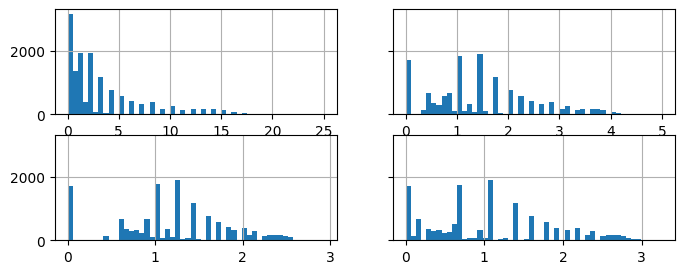

In [7]:
# Visualizo y miro como quedan las modificaciones para buscar una curva mas normal

fig, axs = plt.subplots(2, 2, figsize=(8, 3), sharey=True)
train_set["age"].hist(ax=axs[0,0], bins=50)
train_set["age"].apply(np.sqrt).hist(ax=axs[0,1], bins=50)
train_set["age"].apply(np.cbrt).hist(ax=axs[1,0], bins=50) # me quedo con la raíz cúbica 
train_set["age"].apply(np.log1p).hist(ax=axs[1,1], bins=50)

plt.show()

In [8]:
train_set['age'] = np.cbrt(train_set['age'])

##########################################################################
################################# TEST ###################################
##########################################################################

test_set['age'] = np.cbrt(test_set['age'])

### Tratamiento de features categóricas :

In [9]:
col_cat = ['intake_type','intake_subtype','outcome_type','OutcomeGroup','AKC','AKC_Extended','AgeGroup', 'primary_breed','secondary_breed','Breed']
target = "LOS"
for col in col_cat:
    print(f"MI({col};{target}):", mutual_info_score(train_set[col],train_set[target]))

MI(intake_type;LOS): 0.25898745470055085
MI(intake_subtype;LOS): 0.2671901672876667
MI(outcome_type;LOS): 0.5542683819093519
MI(OutcomeGroup;LOS): 0.40942044597899546
MI(AKC;LOS): 0.04159431728647633
MI(AKC_Extended;LOS): 0.05206678676142375
MI(AgeGroup;LOS): 0.19233115743159035
MI(primary_breed;LOS): 0.19426713972359289
MI(secondary_breed;LOS): 0.11145956952714904
MI(Breed;LOS): 0.1786124181105762


Cuanto mayor sea el valor de MI, mayor será la dependencia o la información compartida entre las variables.

Relevancia alta:
- outcome_type
- OutcomeGroup

(Esto son datos que en la realidad no podremos saber, tiene mucho sentido que tengan relación, pero no las podremos usar para predecir)

Relevancia moderada:
- intake_type
- intake_subtype
- AgeGroup
- primary_breed
- secondary_breed
- Breed

Relevancia baja:
- AKC
- AKC_Extended

In [10]:
exclude.append('outcome_type') # Datos que no podemos saber en la llegada del animal
exclude.append('OutcomeGroup') # Datos que no podemos saber en la llegada del animal
exclude.append('AKC') # Aporta la misma info que AKC_Extended y tiene muy baja relevancia, me voy a quedar con extended para tener la información extra igual

In [11]:
print(train_set['Breed'].value_counts()) # Hay 160 tipo de razas, como tienen la misma informacion y relevancia, me quedo con esta
print(train_set['primary_breed'].value_counts()) #Hay 146 razas

Breed
American Staffordshire Terrier    4421
Labrador Retreiver                1587
Chihuahua                         1169
German Shepherd Dog                644
Shih Tzu                           435
                                  ... 
Clumber Spaniel                      1
German Wirehaired Pointer            1
Bedlington Terrier                   1
Belgian Sheepdog                     1
Dogue de Bordeaux                    1
Name: count, Length: 146, dtype: int64
primary_breed
PIT BULL           3806
LABRADOR RETR      1587
CHIHUAHUA SH       1040
GERM SHEPHERD       644
SHIH TZU            435
                   ... 
BELG SHEEPDOG         1
BEDLINGTON TERR       1
ST BERNARD RGH        1
CLUMBER SPAN          1
DOGUE DE BORDX        1
Name: count, Length: 160, dtype: int64


In [12]:
exclude.append('primary_breed')

In [13]:
col_cat

['intake_type',
 'intake_subtype',
 'outcome_type',
 'OutcomeGroup',
 'AKC',
 'AKC_Extended',
 'AgeGroup',
 'primary_breed',
 'secondary_breed',
 'Breed']

In [14]:
features_def = ['age', 'intake_type','intake_subtype','AKC_Extended','AgeGroup','secondary_breed','Breed']

In [15]:
# Excluyo las fechas:

exclude.append('intake_date')
exclude.append('outcome_date')

In [16]:
# BINARIAS:

from scipy.stats import mannwhitneyu

col_bin = 'KennelCardBreed'
target = 'LOS'

grupo_a = train_set.loc[train_set[col_bin] == "With Breed"][target]
grupo_b = train_set.loc[train_set[col_bin] == "Without Breed"][target]

u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

print("Estadístico U:", u_stat)
print("Valor p:", p_valor)

Estadístico U: 24869792.0
Valor p: 0.013194246707270403


In [17]:
col_bin = 'PitBullType'
target = 'LOS'

grupo_a = train_set.loc[train_set[col_bin] == "Not PB"][target]
grupo_b = train_set.loc[train_set[col_bin] == "Pit Bull"][target]

u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

print("Estadístico U:", u_stat)
print("Valor p:", p_valor)

Estadístico U: 18958363.5
Valor p: 1.398328606414964e-22


In [18]:
col_bin = 'PitBullExpanded'
target = 'LOS'

grupo_a = train_set.loc[train_set[col_bin] == "Not PB"][target]
grupo_b = train_set.loc[train_set[col_bin] == "Pit Bull Exp"][target]

u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

print("Estadístico U:", u_stat)
print("Valor p:", p_valor)

Estadístico U: 18968934.0
Valor p: 6.227032484714264e-23


--> A p más bajo menor seguridad de la existencia de relación:

Relevancia muy muy baja:
- PitBullExpanded
- PitBullType

Relevancia baja:
- KennelCardBreed

In [19]:
# Excluyo las de tipoPitBull y me quedo con KennelCardBreed aunque sea baja la relevancia

features_def.append('KennelCardBreed')
exclude.append('PitBullType')
exclude.append('PitBullExpanded')

In [20]:
features_def

['age',
 'intake_type',
 'intake_subtype',
 'AKC_Extended',
 'AgeGroup',
 'secondary_breed',
 'Breed',
 'KennelCardBreed']

In [21]:
exclude

['animal_id',
 'years_old',
 'months_old',
 'outcome_type',
 'OutcomeGroup',
 'AKC',
 'primary_breed',
 'intake_date',
 'outcome_date',
 'PitBullType',
 'PitBullExpanded']

In [29]:
# Elimino las columnas que no nos interesan:
train_set_clean = train_set.copy()
train_set_clean.drop(columns=exclude, inplace=True)

##########################################################################
################################# TEST ###################################
##########################################################################
test_set_clean = test_set.copy()
test_set_clean.drop(columns=exclude, inplace=True)

train_set_clean # Visualizo train definitivo

,intake_type,intake_subtype,secondary_breed,Breed,AKC_Extended,KennelCardBreed,LOS,AgeGroup,age
0,STRAY,OTC,unknown,Shih Tzu,Toy,With Breed,5,Adult (1-7yr),1.912931
1,OWNER SURR,OTC,unknown,Bichon Frise,Non-sporting,With Breed,6,Adult (1-7yr),1.709976
2,STRAY,OTC,MIX,American Staffordshire Terrier,Pit Bull Types,Without Breed,8,Puppy (0-4mo),0.584804
3,CONFISCATE,BITE,MIX,American Staffordshire Terrier,Pit Bull Types,With Breed,10,Adolescent (5-12mo),1.000000
4,STRAY,OTC,MIX,Border Terrier,Other Terriers,Without Breed,1,Puppy (0-4mo),0.584804
...,...,...,...,...,...,...,...,...,...
13934,STRAY,FIELD,unknown,Boxer,Working,Without Breed,0,Adult (1-7yr),1.259921
13935,STRAY,FIELD,unknown,American Staffordshire Terrier,Pit Bull Types,Without Breed,9,Adolescent (5-12mo),0.887904
13936,STRAY,FIELD,unknown,German Shepherd Dog,Herding,With Breed,1,Adult (1-7yr),1.259921
13937,OWNER SURR,OTC,MIX,American Staffordshire Terrier,Pit Bull Types,With Breed,3,Puppy (0-4mo),0.584804


In [30]:
# Guardo los datasets con sin transformaciones:

train_set_clean.to_csv('../data/CLEAN_train_S4-KCCA.csv', index=False)

test_set_clean.to_csv('../data/CLEAN_test_S4-KCCA.csv', index=False)

-------------------------

#### Últimas transformaciones:

In [23]:
# ONE-HoT encoder de las features categoricas:
# Hago una combinacion para que los dos sets tengan la misma dimension

col_cat_def = ['intake_type', 'intake_subtype', 'AKC_Extended', 'AgeGroup', 'secondary_breed', 'Breed']

combined_set = pd.concat([train_set, test_set], keys=['train', 'test'])

combined_set = pd.get_dummies(combined_set, columns=col_cat_def, dtype = int)

train_set_dummies = combined_set.xs('train')

##########################################################################
################################# TEST ###################################
##########################################################################
test_set_dummies  = combined_set.xs('test')

In [24]:
# Transformo la columna binaria:

train_set_dummies['KennelCardBreed'] = train_set['KennelCardBreed'].map({'With Breed': 1, 'Without Breed': 0})

##########################################################################
################################# TEST ###################################
##########################################################################
test_set_dummies['KennelCardBreed'] = test_set['KennelCardBreed'].map({'With Breed': 1, 'Without Breed': 0})


C:\Users\annav\AppData\Local\Temp\ipykernel_22020\2467064972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_dummies['KennelCardBreed'] = train_set['KennelCardBreed'].map({'With Breed': 1, 'Without Breed': 0})
C:\Users\annav\AppData\Local\Temp\ipykernel_22020\2467064972.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_dummies['KennelCardBreed'] = test_set['KennelCardBreed'].map({'With Breed': 1, 'Without Breed': 0})


In [25]:
# Elimino las columnas que no nos interesan:
train_set_dummies.drop(columns=exclude, inplace=True)

##########################################################################
################################# TEST ###################################
##########################################################################
test_set_dummies.drop(columns=exclude, inplace=True)

train_set_dummies # Visualizo train definitivo

C:\Users\annav\AppData\Local\Temp\ipykernel_22020\3011626485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_dummies.drop(columns=exclude, inplace=True)
C:\Users\annav\AppData\Local\Temp\ipykernel_22020\3011626485.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_dummies.drop(columns=exclude, inplace=True)


,KennelCardBreed,LOS,age,intake_type_CONFISCATE,intake_type_CRUELTY,intake_type_DISPO REQ,intake_type_EUTH REQ,intake_type_FOSTER,intake_type_OWNED,intake_type_OWNER SURR,...,Breed_Vizsla,Breed_Weimaraner,Breed_Welsh Springer Spaniel,Breed_Welsh Terrier,Breed_West Highland White Terrier (Westie),Breed_Whippet,Breed_Wire Fox Terrier,Breed_Wirehaired Pointing Griffon,Breed_Working Kelpie,Breed_Yorkshire Terrier
0,1,5,1.912931,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,6,1.709976,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,8,0.584804,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,10,1.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0.584804,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13934,0,0,1.259921,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13935,0,9,0.887904,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13936,1,1,1.259921,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13937,1,3,0.584804,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Guardo los datasets con sin escalado:

train_set_dummies.to_csv('../data/DUMMIES_train_S4-KCCA.csv', index=False)

test_set_dummies.to_csv('../data/DUMMIES_test_S4-KCCA.csv', index=False)

In [27]:
# Quiero normalizar con valores de 0 a 1:

scaler = MinMaxScaler()

train_set_dummies['age'] = scaler.fit_transform(train_set[['age']])

##########################################################################
################################# TEST ###################################
##########################################################################
test_set_dummies['age'] = scaler.transform(test_set[['age']])

C:\Users\annav\AppData\Local\Temp\ipykernel_22020\3325750862.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_dummies['age'] = scaler.fit_transform(train_set[['age']])
C:\Users\annav\AppData\Local\Temp\ipykernel_22020\3325750862.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_dummies['age'] = scaler.transform(test_set[['age']])


In [28]:
# Guardo los datasets con escalado:

train_set_dummies.to_csv('../data/TRANS_train_S4-KCCA.csv', index=False)

test_set_dummies.to_csv('../data/TRANS_test_S4-KCCA.csv', index=False)